In [193]:

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from IPython.core.display import HTML
import seaborn as sns
import re
%matplotlib inline

css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [194]:
titles = pd.DataFrame.from_csv('movie_metadata.csv', index_col=None)

In [195]:
titles=titles.set_index('movie_title')

In [196]:
titles['ratio']=titles.gross/titles.budget

In [197]:
titles=titles=titles.dropna(axis=0, subset=['imdb_score','gross', 'budget', 'ratio', 'director_facebook_likes' , 'content_rating' , 'title_year' , 'movie_facebook_likes' ])

In [198]:
titles.content_rating.value_counts()

R            1737
PG-13        1331
PG            576
G              91
Not Rated      42
Unrated        24
Approved       17
X              10
NC-17           6
Passed          3
M               2
GP              1
Name: content_rating, dtype: int64

In [199]:
((titles.imdb_score//1)).value_counts()

6.0    1459
7.0    1091
5.0     769
4.0     217
8.0     211
3.0      64
2.0      22
9.0       4
1.0       3
Name: imdb_score, dtype: int64

In [200]:
titles.genres=titles.genres.str.replace("\|.*","")


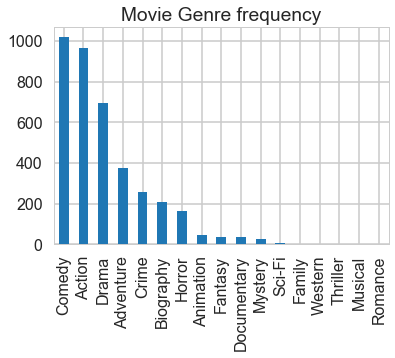

In [201]:
titles.genres.value_counts().plot(kind = 'bar', title='Movie Genre frequency')


In [202]:
def normalize(array1, name):
    print ("normalizing "+name);
    array=array1
    array=array/array.std()
    array=array-array.mean()
    return(array);

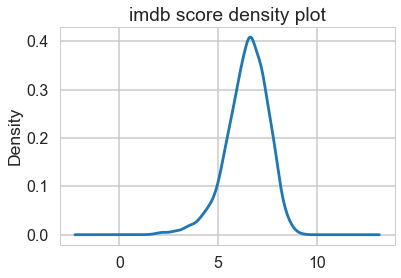

In [203]:
titles.imdb_score.plot.kde(title='imdb score density plot' )

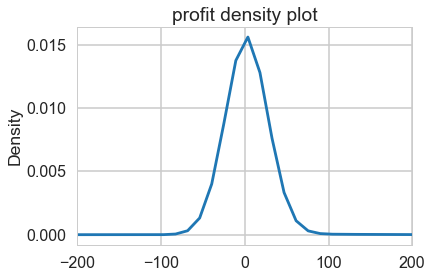

In [204]:
titles.ratio.plot.kde(xlim=[-200,200] , title='profit density plot')

In [205]:
## looking for outliers in profit ratio. To improve efficiency of the model
(titles.ratio//100).value_counts()

0.0     3823
1.0        9
2.0        2
3.0        2
71.0       1
4.0        1
27.0       1
23.0       1
Name: ratio, dtype: int64

In [206]:
## removing movies with a very high profit ratio for wh`ich are mostly low budget movies
titles=titles.drop(titles[(titles.ratio>200)].index)

In [207]:
titles.ratio.mean() , titles.ratio.std() 


(2.7023612667579786, 8.60812467633687)

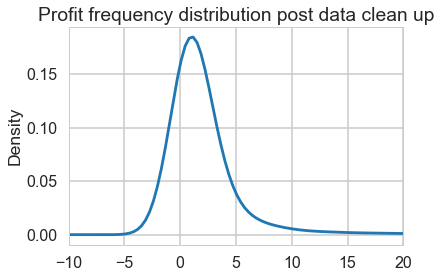

In [208]:
titles.ratio.plot.kde(xlim=[-10,20], title='Profit frequency distribution post data clean up')

In [209]:
len(titles[(titles.ratio > 18)])

75

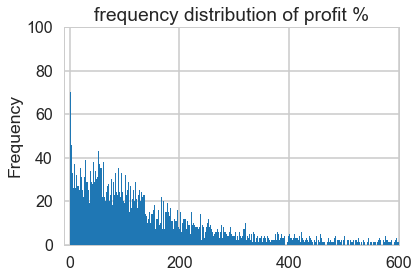

In [210]:
# %profit distribution
(titles.ratio*100).plot.hist(xlim=[-10,600],ylim=[0,100],bins=10000,title="frequency distribution of profit %")


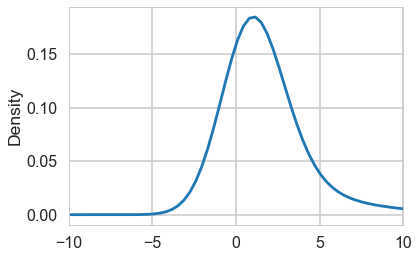

In [211]:
# profit density plot
(titles.ratio).plot.kde(xlim=[-10,10])

In [212]:
titles.ratio.mean() , titles.ratio.std() , titles.ratio.median() 

(2.7023612667579786, 8.60812467633687, 1.081657044736842)

In [213]:
len(titles[(titles.ratio > 10)])

148

In [214]:
## defining profit making movie. Criterion is 20% profit.
titles['profit_making']= (titles.ratio > 1.2)

In [215]:
titles.profit_making.value_counts()

False    2059
True     1773
Name: profit_making, dtype: int64

In [216]:
##  sending budget and likes through normalizer


In [217]:
for column in ['budget','movie_facebook_likes','cast_total_facebook_likes','director_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes','duration','num_voted_users', 'num_user_for_reviews', 'gross']:
    if np.issubdtype(titles[column].dtype, np.number):
        print (column + ": true")
        titles[column]=normalize(array1=titles[column],name=column)
    else:
        print (column + ":false")

budget: true
normalizing budget
movie_facebook_likes: true
normalizing movie_facebook_likes
cast_total_facebook_likes: true
normalizing cast_total_facebook_likes
director_facebook_likes: true
normalizing director_facebook_likes
actor_1_facebook_likes: true
normalizing actor_1_facebook_likes
actor_2_facebook_likes: true
normalizing actor_2_facebook_likes
duration: true
normalizing duration
num_voted_users: true
normalizing num_voted_users
num_user_for_reviews: true
normalizing num_user_for_reviews
gross: true
normalizing gross


In [218]:
titles.budget.median()

-0.09189160544010078

In [219]:
titles2 = pd.DataFrame.from_csv('movie_metadata.csv', index_col=None)

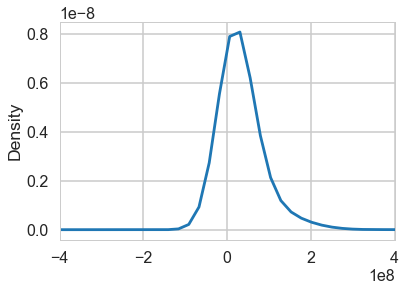

In [220]:
titles2.budget.plot.kde(xlim=[-.4e9,.4e9])

In [221]:
titles2.budget.mean()

39752620.436387606

In [222]:
titles2.budget.std()


206114898.44868386

In [223]:
temp1=((titles2.budget//1e6)*(1e6)).value_counts().sort_index()

In [224]:
temp1=((titles.ratio//.5)*.5).value_counts().sort_index()

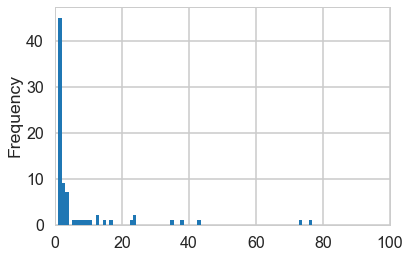

In [225]:
temp1.plot.hist(bins=1000 , xlim=[0,100]  )

In [226]:
temp1=((titles2.budget//1000000)*(1000000)).value_counts().sort_index()


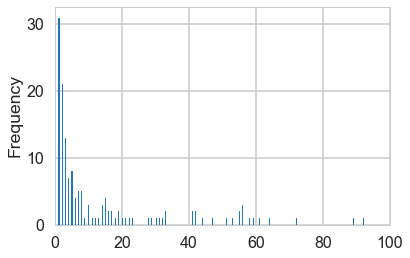

In [227]:
temp1.plot.hist(bins=1000 , xlim=[0,100]  )

In [228]:
titles2.budget.mean()

39752620.436387606

In [229]:
titles[titles.country.str.match("South Korea")].budget

movie_title
Snowpiercer                            -0.028456
Dragon Wars: D-War                     -0.047219
The Last Godfather                     -0.143712
Tae Guk Gi: The Brotherhood of War     -0.146392
The Host                               54.366469
The Good, the Bad, the Weird           -0.158901
Lady Vengeance                         18.558997
Oldboy                                 -0.190172
Name: budget, dtype: float64

In [230]:
titles_highb = titles[(titles.budget > -.114)]

In [231]:
titles_lowb = titles[(titles.budget <= -.114)]

In [232]:
len(titles_highb)

2052

In [233]:
len(titles_lowb)

1780

In [234]:
titles_highb.profit_making.mean()

0.40692007797270957

In [235]:
titles_highb.sort_values('budget', ascending=False)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,ratio,profit_making
movie_title,,,,,,,,,,,,,,,,,,,,,
The Host,Color,Joon-ho Bong,363.0,-0.002081,-0.068531,74.0,Kang-ho Song,-0.455938,-0.707090,Comedy,...,South Korea,R,54.366469,2006.0,-0.353850,7.0,1.85,-0.105765,0.000180,False
Lady Vengeance,Color,Chan-wook Park,202.0,0.086512,-0.260670,38.0,Yeong-ae Lee,-0.450239,-0.735491,Crime,...,South Korea,R,18.558997,2005.0,-0.414150,7.7,2.35,-0.245709,0.000050,False
Fateless,Color,Lajos Koltai,73.0,1.061028,-0.245865,0.0,Péter Fancsikai,-0.496095,-0.735716,Drama,...,Hungary,R,10.964623,2005.0,-0.441640,7.1,2.35,-0.403986,0.000078,False
Princess Mononoke,Color,Hayao Miyazaki,174.0,1.061028,1.713358,745.0,Jada Pinkett Smith,-0.438840,-0.705709,Adventure,...,Japan,PG-13,10.517895,1997.0,-0.253424,8.4,1.85,0.080827,0.000958,False
Steamboy,Color,Katsuhiro Ôtomo,105.0,-0.312154,-0.235007,101.0,Robin Atkin Downes,-0.465071,-0.732654,Action,...,Japan,PG-13,9.300651,2004.0,-0.367595,6.9,1.85,-0.386913,0.000193,False
Akira,Color,Katsuhiro Ôtomo,150.0,0.618066,-0.235007,4.0,Takeshi Kusao,-0.496289,-0.732244,Action,...,Japan,R,4.710433,1988.0,-0.440975,8.1,1.85,-0.432301,0.000399,False
Godzilla 2000,Color,Takao Okawara,107.0,-0.489339,-0.260012,3.0,Naomi Nishida,-0.493893,-0.595242,Action,...,Japan,PG,4.263705,1999.0,-0.441418,6.0,2.35,-0.416488,0.010037,False
Kabhi Alvida Naa Kehna,Color,Karan Johar,20.0,3.674503,-0.208029,860.0,John Abraham,0.021470,-0.691760,Drama,...,India,R,2.923522,2006.0,-0.220391,6.0,2.35,-0.401560,0.004679,False
Tango,Color,Carlos Saura,35.0,0.219400,-0.228427,4.0,Juan Luis Galiardo,-0.474592,-0.714428,Drama,...,Spain,PG-13,2.923522,1998.0,-0.436319,7.2,2.00,-0.407158,0.002410,False


In [236]:
titles_lowb.profit_making.mean()

0.52696629213483148

In [237]:
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle


In [238]:
titles_highb=shuffle(titles_highb)

In [239]:
titles_highb.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,ratio,profit_making
movie_title,,,,,,,,,,,,,,,,,,,,,
The Longshots,Color,Fred Durst,47.0,-0.710820,-0.175787,424.0,Dash Mihok,-0.449980,-0.574245,Biography,...,USA,PG,-0.100826,2008.0,-0.339440,5.1,2.35,-0.414762,0.500366,False
Men in Black,Color,Barry Sonnenfeld,175.0,-0.533635,-0.198817,602.0,Rip Torn,0.151007,2.832011,Adventure,...,USA,PG-13,0.198482,1997.0,-0.258966,7.3,1.85,-0.432301,2.779418,True
Cleopatra,Color,Joseph L. Mankiewicz,72.0,6.243682,-0.158349,595.0,Richard Burton,-0.435795,0.085792,Biography,...,UK,Approved,-0.064574,1963.0,-0.281135,7.0,2.20,-0.432301,1.856018,True
How to Lose Friends & Alienate People,Color,Robert B. Weide,135.0,-0.002081,-0.243232,87.0,Katherine Parkinson,-0.465589,-0.698894,Comedy,...,UK,R,-0.082957,2008.0,-0.384222,6.5,1.85,-0.432301,0.102800,False
The Age of Innocence,Color,Martin Scorsese,56.0,1.282509,5.332410,94.0,Geraldine Chaplin,-0.460796,-0.281755,Drama,...,USA,PG,-0.069555,1993.0,-0.357397,7.2,2.35,-0.432301,1.066667,False


In [240]:
titles_highb=titles_highb[['imdb_score','gross', 'budget', 'ratio', 'director_facebook_likes' , 'content_rating' , 'title_year' , 'movie_facebook_likes' ,'actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes']]

In [241]:
titles_highb=titles_highb.dropna(axis=0, subset = ['actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes'])

In [242]:
titles_highb_train=titles_highb[:1500]
titles_highb_test=titles_highb[1500:]

In [243]:
linear_regression_highb= LinearRegression()

In [244]:
linear_regression_highb.fit(titles_highb_train[['title_year','budget','imdb_score','director_facebook_likes' ,  'actor_1_facebook_likes', 'actor_2_facebook_likes' , 'actor_3_facebook_likes']] , titles_highb_train.ratio)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [245]:
linear_regression_highb.predict(titles_highb_test[['title_year','budget','imdb_score','director_facebook_likes' ,  'actor_1_facebook_likes', 'actor_2_facebook_likes' , 'actor_3_facebook_likes']])[:10]

array([ 1.24752026,  1.18258967,  1.46536268,  1.19312631,  1.54266559,
        1.66617633,  1.37939537,  1.11881243,  1.11049126,  1.17106323])

In [246]:
titles_highb_test.ratio[:10]

movie_title
Last Holiday              0.852449
Man on a Ledge            0.442879
Big Hero 6                1.348410
Chasing Liberty           0.529979
Amen.                     0.002663
Man on the Moon           0.665012
Signs                     3.166190
Delivery Man              1.179224
Jingle All the Way        1.009561
Babe: Pig in the City     0.228975
Name: ratio, dtype: float64

In [247]:
linear_regression_highb.score(titles_highb_test[['title_year','budget','imdb_score','director_facebook_likes' ,  'actor_1_facebook_likes', 'actor_2_facebook_likes' , 'actor_3_facebook_likes' ]],titles_highb_test.ratio)

0.010068156182267418

In [248]:
linear_regression_highb.coef_

array([ -1.83213712e-02,  -1.95006312e-01,   3.11510103e-01,
         2.21014409e-02,   3.05718429e-02,   1.18710932e-03,
         3.94092562e-05])

In [249]:
new=titles.genres.drop_duplicates()

In [250]:
new.sort_values

<bound method Series.sort_values of movie_title
Avatar                           Action
Tangled                       Adventure
Titanic                           Drama
A Christmas Carol             Animation
Evan Almighty                    Comedy
Angels & Demons                 Mystery
Ocean's Twelve                    Crime
The Aviator                   Biography
The Haunting                    Fantasy
Oceans                      Documentary
The Invasion                     Sci-Fi
Exorcist: The Beginning          Horror
The Adjustment Bureau           Romance
The Nutcracker                   Family
Pale Rider                      Western
Grease                          Musical
Locker 13                      Thriller
Name: genres, dtype: object>

In [251]:
titles_cat=titles

In [252]:
from pandas import get_dummies 

In [253]:
type (titles_cat)

pandas.core.frame.DataFrame

In [254]:
titles_cat=pd.get_dummies(titles_cat , columns=["genres"])

In [255]:
titles_cat.genres_Action.head()

movie_title
Avatar                                       1
Pirates of the Caribbean: At World's End     1
Spectre                                      1
The Dark Knight Rises                        1
John Carter                                  1
Name: genres_Action, dtype: uint8

In [256]:
titles_cat.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language',
       'country', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'ratio', 'profit_making', 'genres_Action',
       'genres_Adventure', 'genres_Animation', 'genres_Biography',
       'genres_Comedy', 'genres_Crime', 'genres_Documentary', 'genres_Drama',
       'genres_Family', 'genres_Fantasy', 'genres_Horror', 'genres_Musical',
       'genres_Mystery', 'genres_Romance', 'genres_Sci-Fi', 'genres_Thriller',
       'genres_Western'],
      dtype='object')

In [257]:
titles_cat.content_rating.value_counts()

R            1730
PG-13        1331
PG            576
G              91
Not Rated      42
Unrated        23
Approved       17
X              10
NC-17           6
Passed          3
M               2
GP              1
Name: content_rating, dtype: int64

In [258]:
titles_cat.sort_values('budget', ascending=False).country

movie_title
The Host                                        South Korea
Lady Vengeance                                  South Korea
Fateless                                            Hungary
Princess Mononoke                                     Japan
Steamboy                                              Japan
Akira                                                 Japan
Godzilla 2000                                         Japan
Kabhi Alvida Naa Kehna                                India
Tango                                                 Spain
Red Cliff                                             China
The Legend of Suriyothai                           Thailand
The Messenger: The Story of Joan of Arc              France
Ong-bak 2                                          Thailand
Pirates of the Caribbean: At World's End                USA
John Carter                                             USA
Tangled                                                 USA
Spider-Man 3                

In [259]:
titles_cat=titles_cat.drop(titles_cat[titles_cat.content_rating.str.match("NC-17|Passed|M|GP")].index)

In [260]:
titles_cat.content_rating.value_counts()

R            1730
PG-13        1331
PG            576
G              91
Not Rated      42
Unrated        23
Approved       17
X              10
Name: content_rating, dtype: int64

In [261]:
titles_cat=pd.get_dummies(titles_cat , columns=["content_rating"])

In [262]:
titles_cat_highb = titles_cat[(titles_cat.budget > -.114)]

In [263]:
titles_cat_lowb = titles_cat[(titles_cat.budget <= -.114)]

In [264]:
len(titles_cat_highb)

2051

In [265]:
len(titles_cat_lowb)

1769

In [266]:
titles_cat_highb.profit_making.mean()

0.40711847879083374

In [267]:
titles_cat_lowb.profit_making.mean()

0.52572074618428488

In [268]:
titles_cat_highb=shuffle(titles_cat_highb)

In [269]:
titles_cat_highb.columns


Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language',
       'country', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'ratio',
       'profit_making', 'genres_Action', 'genres_Adventure',
       'genres_Animation', 'genres_Biography', 'genres_Comedy', 'genres_Crime',
       'genres_Documentary', 'genres_Drama', 'genres_Family', 'genres_Fantasy',
       'genres_Horror', 'genres_Musical', 'genres_Mystery', 'genres_Romance',
       'genres_Sci-Fi', 'genres_Thriller', 'genres_Western',
       'content_rating_Approved', 'content_rating_G',
       'content_rating_Not Rated', 'content_rating_PG', 'content_rati

In [270]:
#titles_cat_highb.drop(titles_cat_highb.country==)

In [271]:
len(titles_cat_highb[titles_cat_highb.country != "USA"])

339

In [272]:
titles_cat_highb=titles_cat_highb.drop(titles_cat_highb[titles_cat_highb.country != "USA"].index)

In [273]:
#titles_cat_highb=titles_cat_highb.drop(['actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes'],axis=1)

In [274]:
titles_cat_highb.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language',
       'country', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'ratio',
       'profit_making', 'genres_Action', 'genres_Adventure',
       'genres_Animation', 'genres_Biography', 'genres_Comedy', 'genres_Crime',
       'genres_Documentary', 'genres_Drama', 'genres_Family', 'genres_Fantasy',
       'genres_Horror', 'genres_Musical', 'genres_Mystery', 'genres_Romance',
       'genres_Sci-Fi', 'genres_Thriller', 'genres_Western',
       'content_rating_Approved', 'content_rating_G',
       'content_rating_Not Rated', 'content_rating_PG', 'content_rati

In [275]:
titles_cat_ml_highb=titles_cat_highb.select_dtypes(exclude=['object']) 

In [276]:
titles_cat_ml_highb=titles_cat_ml_highb.select_dtypes(exclude=['bool']) 

In [277]:
titles_cat_ml_highb=titles_cat_ml_highb.dropna()

In [278]:
titles_cat_ml_highb=shuffle(titles_cat_ml_highb)

In [279]:
titles_cat_ml_highb.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'ratio', 'genres_Action', 'genres_Adventure',
       'genres_Animation', 'genres_Biography', 'genres_Comedy', 'genres_Crime',
       'genres_Documentary', 'genres_Drama', 'genres_Family', 'genres_Fantasy',
       'genres_Horror', 'genres_Musical', 'genres_Mystery', 'genres_Romance',
       'genres_Sci-Fi', 'genres_Thriller', 'genres_Western',
       'content_rating_Approved', 'content_rating_G',
       'content_rating_Not Rated', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R', 'content_rating_Unrated', 'content_rating_X'],
      dtype='object')

In [280]:
titles_cat_ml_highb_train=titles_cat_ml_highb[:1200]
titles_cat_ml_highb_test=titles_cat_ml_highb[1200:]

In [281]:
titles_cat_ml_highb_train_x=titles_cat_ml_highb_train.drop(['gross', 'ratio'],axis=1 )

In [282]:
titles_cat_ml_highb_test_x=titles_cat_ml_highb_test.drop( ['ratio' , 'gross' ],axis=1)

In [283]:
titles_cat_ml_highb_train_y=pd.DataFrame(titles_cat_ml_highb_train['ratio'])

In [284]:
titles_cat_ml_highb_test_y=pd.DataFrame(titles_cat_ml_highb_test[ 'ratio' ])

In [285]:
linear_regression_highb_cat= LinearRegression()

In [286]:
linear_regression_highb_cat.fit(titles_cat_ml_highb_train_x ,titles_cat_ml_highb_train_y )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [287]:
linear_regression_highb_cat.predict(titles_cat_ml_highb_train_x)[:10]

array([[ 0.94672535],
       [ 2.02929527],
       [ 0.78012941],
       [ 0.92075055],
       [ 1.63383713],
       [ 0.86385517],
       [ 2.2566237 ],
       [ 1.36924224],
       [ 0.98176268],
       [ 0.52988096]])

In [288]:
titles_cat_ml_highb_train_y[:10]

,ratio
movie_title,
The Day the Earth Stood Still,0.992047
The Running Man,1.411930
Changeling,0.649224
The Core,0.518521
Sweet Home Alabama,3.347739
In the Heart of the Sea,0.249856
X-Men: First Class,0.915034
RoboCop,0.586070
Funny People,0.690856


In [289]:
linear_regression_highb_cat.score(titles_cat_ml_highb_test_x,titles_cat_ml_highb_test_y)

0.2158916069146366

In [290]:
linear_regression_highb_cat.coef_

array([[  2.35804531e-03,  -4.98115171e-02,  -9.03322328e-02,
         -1.01897398e-04,  -1.17005585e+00,   4.36110878e-01,
          1.48855750e+00,   4.44068578e-03,  -4.96571897e-02,
         -2.41335152e+00,  -3.26654814e-02,  -3.53731475e-01,
          1.77275682e-01,  -2.00177539e-01,  -4.06122848e-02,
          2.17873627e-01,   2.94953290e-01,   2.58562009e-01,
          1.90578147e-01,   4.47089250e-01,  -2.76328072e-02,
          6.03748348e-02,   4.79223598e-02,  -1.09634524e-15,
         -3.27164929e-02,   2.69500229e-01,  -3.33066907e-16,
         -9.14048409e-02,  -7.08336170e-01,  -9.26763434e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.22415770e-01,   0.00000000e+00,   1.88369530e-01,
         -7.36290430e-02,  -4.37156257e-01,   0.00000000e+00,
          0.00000000e+00]])

In [291]:
titles_cat_ml_highb_test_x.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users',
       'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'genres_Action', 'genres_Adventure',
       'genres_Animation', 'genres_Biography', 'genres_Comedy', 'genres_Crime',
       'genres_Documentary', 'genres_Drama', 'genres_Family', 'genres_Fantasy',
       'genres_Horror', 'genres_Musical', 'genres_Mystery', 'genres_Romance',
       'genres_Sci-Fi', 'genres_Thriller', 'genres_Western',
       'content_rating_Approved', 'content_rating_G',
       'content_rating_Not Rated', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R', 'content_rating_Unrated', 'content_rating_X'],
      dtype='object')

In [292]:
titles2 = pd.DataFrame.from_csv('movie_metadata.csv', index_col=None)

In [293]:
titles2=titles2.set_index('movie_title')

In [294]:

titles2['ratio']=titles2.gross/titles2.budget

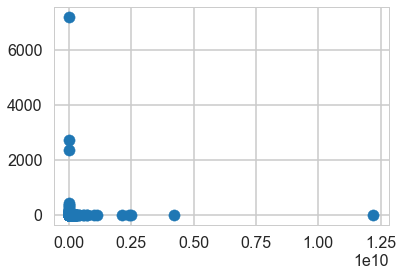

In [295]:
plt.ylim=[0,500]
plt.xlim=[0,.2e10]
plt.scatter(titles2.budget , titles2.ratio)

In [296]:
titles2=titles2.drop(titles2[titles2.country!="USA"].index)

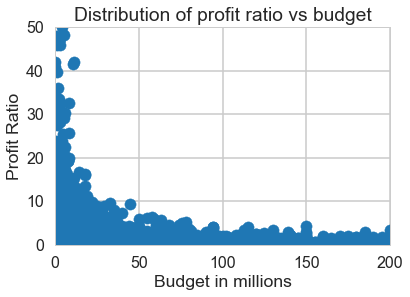

In [297]:
#plt.ylim=[0,500]
#plt.xlim=[0,.2e10]
plt.axis([0,200,0,50])
plt.xlabel('Budget in millions')
plt.ylabel('Profit Ratio')
plt.title('Distribution of profit ratio vs budget')
plt.scatter(titles2.budget/(1e6) , titles2.ratio)

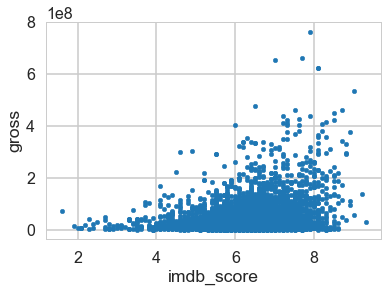

In [298]:
titles2.plot.scatter(x='imdb_score',y='gross')

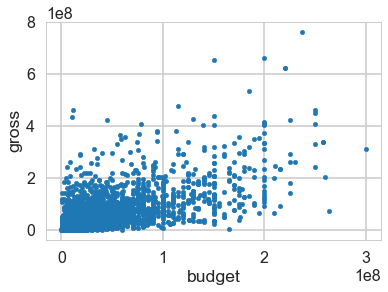

In [299]:
titles2.plot.scatter(x='budget',y='gross')

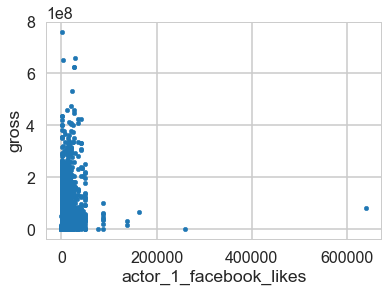

In [300]:
titles2.plot.scatter(x='actor_1_facebook_likes',y='gross')

In [301]:
titles2.actor_1_facebook_likes.std()

16655.361604538255

In [302]:
#Logistic Regression #####

In [303]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [304]:
logistic_regression_1= LogisticRegression()

In [305]:
titles_cat_ml_highb=titles_cat_highb.select_dtypes(exclude=['object']) 

In [306]:
titles_cat_ml_highb_ratio=titles_cat_ml_highb.ratio

In [307]:
titles_cat_logistic_highb=titles_cat_ml_highb.drop(['ratio'], axis=1)

In [308]:
titles_cat_logistic_highb=titles_cat_logistic_highb.dropna()

In [309]:
titles_cat_logistic_highb=shuffle(titles_cat_logistic_highb)

In [310]:
titles_cat_logistic_highb_train=titles_cat_logistic_highb[:1200]
titles_cat_logistic_highb_test=titles_cat_logistic_highb[1200:]

In [311]:
titles_cat_logistic_highb_train_x=titles_cat_logistic_highb_train.drop(['gross', 'profit_making','movie_facebook_likes','num_voted_users'],axis=1 )

In [312]:
titles_cat_logistic_highb_test_x=titles_cat_logistic_highb_test.drop( ['gross', 'profit_making','movie_facebook_likes','num_voted_users' ],axis=1)

In [313]:
titles_cat_logistic_highb_train_y=pd.DataFrame(titles_cat_logistic_highb_train['profit_making'])

In [314]:
titles_cat_logistic_highb_test_y=pd.DataFrame(titles_cat_logistic_highb_test[ 'profit_making' ])

In [315]:
logistic_regression_1.fit(titles_cat_logistic_highb_train_x,titles_cat_logistic_highb_train_y.profit_making)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [316]:
accuracy_score(logistic_regression_1.predict(titles_cat_logistic_highb_test_x),titles_cat_logistic_highb_test_y.profit_making)

0.68774703557312256

In [317]:
titles_cat_logistic_highb_test_x.index[:10]

Index(['Coraline ', 'Little Nicky ', 'Joyful Noise ', 'War of the Worlds ',
       'Blade ', 'Unfaithful ', 'The Conspirator ', 'The Devil Wears Prada ',
       'G.I. Joe: Retaliation ', 'Robots '],
      dtype='object', name='movie_title')

In [318]:
logistic_regression_2=LogisticRegression()

In [319]:
titles_cat_lowb=titles_cat_lowb.drop(titles_cat_lowb[titles_cat_lowb.country!="USA"].index)

In [320]:
titles_cat_ml_lowb=titles_cat_lowb.select_dtypes(exclude=['object']) 

In [321]:
titles_cat_ml_lowb_ratio=titles_cat_ml_lowb.ratio

In [322]:
titles_cat_logistic_lowb=titles_cat_ml_lowb.drop(['ratio'], axis=1)

In [323]:
titles_cat_logistic_lowb=titles_cat_logistic_lowb.dropna()

In [324]:
titles_cat_logistic_lowb=shuffle(titles_cat_logistic_lowb)

In [325]:
titles_cat_logistic_lowb_train=titles_cat_logistic_lowb[:1200]
titles_cat_logistic_lowb_test=titles_cat_logistic_lowb[1200:]

In [326]:
titles_cat_logistic_lowb_train_x=titles_cat_logistic_lowb_train.drop(['gross', 'profit_making','movie_facebook_likes','num_voted_users'],axis=1 )

In [327]:
titles_cat_logistic_lowb_test_x=titles_cat_logistic_lowb_test.drop( ['gross', 'profit_making','movie_facebook_likes','num_voted_users'],axis=1)

In [328]:
titles_cat_logistic_lowb_train_y=pd.DataFrame(titles_cat_logistic_lowb_train['profit_making'])

In [329]:
titles_cat_logistic_lowb_test_y=pd.DataFrame(titles_cat_logistic_lowb_test[ 'profit_making' ])

In [330]:
logistic_regression_2.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [331]:
accuracy_score(logistic_regression_2.predict(titles_cat_logistic_lowb_test_x),titles_cat_logistic_lowb_test_y.profit_making)

0.72602739726027399

In [332]:
accuracy_score(logistic_regression_2.predict(titles_cat_logistic_lowb_train_x),titles_cat_logistic_lowb_train_y.profit_making)

0.69666666666666666

In [333]:
##SVM technique

In [334]:
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [335]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=10, C=.1))
])


In [336]:
poly_kernel_svm_clf.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.1, cache_size=200, class_weight=None, coef0=10,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [337]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

0.78082191780821919

In [338]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)

0.78083333333333338

In [339]:
titles_cat_logistic_lowb_train_x_noimdb=titles_cat_logistic_lowb_train_x.drop('imdb_score',axis=1)

In [340]:
titles_cat_logistic_lowb_test_x_noimdb=titles_cat_logistic_lowb_test_x.drop('imdb_score',axis=1)

In [341]:
lgr = Pipeline([
        ("scaler", StandardScaler()),
        ("lgr_clf", LogisticRegression(C=.1))
])

In [342]:
lgr.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgr_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [343]:
lgr.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.76712328767123283

In [344]:
lgr.score(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

0.71916666666666662

In [345]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=10, C=.01))
])

In [346]:
poly_kernel_svm_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.01, cache_size=200, class_weight=None, coef0=10,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [347]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.75342465753424659

In [348]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

0.73499999999999999

In [349]:
## Decision Trees


In [350]:
##Voting


In [351]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

voting_clf = VotingClassifier(
       estimators=[('lr',lgr ),  ('svc', poly_kernel_svm_clf)],
       #estimators=[('svc', poly_kernel_svm_clf)],
    voting='hard')
#voting_clf.fit(X_train, y_train)


In [352]:
voting_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making )

VotingClassifier(estimators=[('lr', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgr_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          pena... max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [353]:
voting_clf.estimators

[('lr', Pipeline(memory=None,
       steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgr_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))])), ('svc', Pipeline(memory=None,
       steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.01, cache_size=200, class_weight=None, coef0=10,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]))]

In [354]:
voting_clf.score(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

0.72750000000000004

In [355]:
voting_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.78082191780821919

In [356]:
## Random forest / Bagging/ Pasting /Boosting

In [357]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=100, n_jobs=-1, random_state=42)

In [358]:
rnd_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=100,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [359]:
rnd_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.75342465753424659

In [360]:

voting_clf = VotingClassifier(
       estimators=[('lr',lgr ),  ('svc', poly_kernel_svm_clf),  ('rnd', rnd_clf)],
       #estimators=[('svc', poly_kernel_svm_clf)],
    voting='hard')
#voting_clf.fit(X_train, y_train)


In [361]:
voting_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making )

VotingClassifier(estimators=[('lr', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgr_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          pena...mators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [362]:
voting_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.75342465753424659

In [1057]:
## Other stuff

In [1058]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

NameError: name 'X' is not defined